In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import glob
import warnings
import seaborn as sns
import math 
warnings.filterwarnings('ignore')

import files

In [3]:
all_files=[]
for i in range(1,15):
    path = r'C:\Users\yev\Desktop\Data_Signals\EarlyWarningSignalsInMotionInference-master\Exp1\GS_Pair_' +str(i)
    all_files += glob.glob(path + "/*.csv")
    
all_df = {}
for i in range(len(all_files)):
    all_df[i] = pd.read_csv(all_files[i], index_col=False)

In [4]:
def organize_data(data_frame):
    columns = ['trial ', ' timeA ', ' yA ', ' zA ', ' xA ']
    for k in 'xyz': 
        for i in range(3,9):
            columns.append(str(k) + 'As' + str(i))
    df =data_frame[columns]
    for k in 'xyz': 
        for i in [1,3,4,5,6,7,8]:
            df['diff_'+str(k)+str(i)]=1
    for i in [1,3,4,5,6,7,8]:
        df['V'+str(i)]=1
    mat= np.array(df.iloc[:,2:])
    for raw in range(1,len(mat)):
        mat[raw,21:42]=(mat[raw,0:21]-mat[raw-1,0:21])/(df.iloc[raw,1]-df.iloc[raw-1,1])
    df.iloc[:,2:]=mat
    v1,v3,v4,v5,v6,v7,v8=[0],[0],[0],[0],[0],[0],[0]
    for i in range(1,len(df)):
        v1.append(((df['diff_y1'][i])**2+(df['diff_z1'][i])**2+(df['diff_x1'][i])**2)**0.5)
        v3.append(((df['diff_y3'][i])**2+(df['diff_z3'][i])**2+(df['diff_x3'][i])**2)**0.5)
        v4.append(((df['diff_y4'][i])**2+(df['diff_z4'][i])**2+(df['diff_x4'][i])**2)**0.5)
        v5.append(((df['diff_y5'][i])**2+(df['diff_z5'][i])**2+(df['diff_x5'][i])**2)**0.5)
        v6.append(((df['diff_y6'][i])**2+(df['diff_z6'][i])**2+(df['diff_x6'][i])**2)**0.5)
        v7.append(((df['diff_y7'][i])**2+(df['diff_z7'][i])**2+(df['diff_x7'][i])**2)**0.5)
        v8.append(((df['diff_y8'][i])**2+(df['diff_z8'][i])**2+(df['diff_x8'][i])**2)**0.5)
    df['V1']=v1
    df['V3']=v3
    df['V4']=v4
    df['V5']=v5
    df['V6']=v6
    df['V7']=v7
    df['V8']=v8
    badRows=df.groupby('trial ').head(5)
    df=pd.concat([df, badRows]).drop_duplicates(keep=False)
    return df

In [5]:
df_org= {}
for i in range(len(all_df)):
    df_org[i]=organize_data(all_df[i])  
    
def organize_by_trail(data_frame):
    trail =np.array(data_frame['trial '])
    indexs={}
    for i in range(1,31):
        indexs[i]=np.where(trail==i,True,False)
    df_by_trail={}
    for i in range(1,31):
        df_by_trail[i]=data_frame.iloc[indexs[i],:].reset_index()
    return df_by_trail
    
df_trail= []
for i in range(len(df_org)):
    df_trail.append(organize_by_trail(df_org[i]))

In [50]:
#Plot std head vs finger x-coordinate
def stdFingerHead(numcsv,numtrail):
    window=10
    std = []
    std1 = []
    for i in range(len(df_trail[numcsv][numtrail])-window):
        std.append(df_trail[numcsv][numtrail]['xAs4'][i:i+window].std())
    for i in range(len(df_trail[numcsv][numtrail])-window):
        std1.append(df_trail[numcsv][numtrail][' xA '][i:i+window].std())
    plt.figure(figsize=(10, 10), dpi=80)
    plt.plot(np.arange(len(std)),std,label = 'xelbow')
    plt.plot(np.arange(len(std1)),std1,label = 'finger')
    plt.xlabel('Time-window')
    plt.ylabel('X-coordinates')
    plt.legend()

Interactive plot - 

Input: csv number , trail number

In [48]:

import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

class Display:

    def __init__(self,numcsv,numtrail,rand=3.0, num_points=0, slope=1.0):
        self.numcsv = numcsv
        self.numtrail = numtrail
        self.num_points = num_points
        self.output_widget = widgets.Output()  # will contain the plot
        self.container = widgets.VBox()  # Contains the whole app
        self.redraw_whole_plot()
        self.draw_app()

    def draw_app(self):
        """
        Draw the sliders and the output widget

        This just runs once at app startup.
        """
        self.num_points_slider = widgets.IntSlider(
            value=self.num_points,
            min=df_trail[self.numcsv][self.numtrail].index[0],
            max=df_trail[self.numcsv][self.numtrail].index[-1],
            step=1,
            description='Number of points:'
        )
        self.num_points_slider.observe(self._on_num_points_change, ['value'])
       
        self.container.children = [
            self.num_points_slider,
            self.output_widget
        ]

    def _on_num_points_change(self, _):
        """
        Called whenever the number of points slider changes.

        Updates the internal state, recomputes the random x and y and redraws the plot.
        """
        self.num_points = self.num_points_slider.value
        self.redraw_whole_plot()


    def redraw_whole_plot(self):
        """
        Recompute x and y random variates and redraw whole plot

        Called whenever the number of points or the randomness changes.
        """
        self.x =df_trail[self.numcsv][self.numtrail][' xA '][0: self.num_points]
        self.y =df_trail[self.numcsv][self.numtrail][' yA '][0: self.num_points]
        self.x3 =df_trail[self.numcsv][self.numtrail]['xAs3'][0: self.num_points]
        self.y3 =df_trail[self.numcsv][self.numtrail]['yAs3'][0: self.num_points]
        self.x4 =df_trail[self.numcsv][self.numtrail]['xAs4'][0: self.num_points]
        self.y4 =df_trail[self.numcsv][self.numtrail]['yAs4'][0: self.num_points]
        self.x5 =df_trail[self.numcsv][self.numtrail]['xAs5'][0: self.num_points]
        self.y5 =df_trail[self.numcsv][self.numtrail]['yAs5'][0: self.num_points]
        self.x6 =df_trail[self.numcsv][self.numtrail]['xAs6'][0: self.num_points]
        self.y6 =df_trail[self.numcsv][self.numtrail]['yAs6'][0: self.num_points]
        self.x7 =df_trail[self.numcsv][self.numtrail]['xAs7'][0: self.num_points]
        self.y7 =df_trail[self.numcsv][self.numtrail]['yAs7'][0: self.num_points]
        self.x8 =df_trail[self.numcsv][self.numtrail]['xAs8'][0: self.num_points]
        self.y8 =df_trail[self.numcsv][self.numtrail]['yAs8'][0: self.num_points]
   
        self.redraw_slope()

    def redraw_slope(self):
        """
        Recompute slope line and redraw whole plot

        Called whenever the slope changes.
        """

        self.output_widget.clear_output(wait=True)
        with self.output_widget as f:
            plt.figure(figsize=(10, 10), dpi=80)
            plt.ylim(ymin=0,ymax=80)
            plt.xlim(xmin=-20,xmax=30)
            plt.scatter(self.x, self.y, label='Right Finger')
            plt.scatter(self.x3, self.y3, label='Right Wrist')
            plt.scatter(self.x4, self.y4, label='Right Elbow')   
            plt.scatter(self.x5, self.y5,label='Right Shoulder')   
            plt.scatter(self.x6, self.y6, label = "Left Shoulder")
            plt.scatter(self.x7, self.y7, label = 'Center Mass')   
            plt.scatter(self.x8, self.y8, label = 'Head')
            plt.legend()
            plt.xlabel('X-coordinates')
            plt.ylabel('Y-coordinates')
           
            plt.show()


In [8]:
#finger move timing
def finger_move(velocity):
    res =[velocity[0]]
    for i in range(30,len(velocity)):
        if len(res)>6:
            return list(velocity).index(min(res))
        elif velocity[i] > max(res):
            res.append(velocity[i])
        else:
            res =[velocity[i]]
#finger move to left or right
def right_left(x_coordinate):
    if x_coordinate.max()>5:
        return 1
    else:
        return 0
#differnce in coordinate x 20 time windows before finger starts to move (wrist)
def ind_d(data,finger, num_trail):
    ans= data[i]['xAs3'][finger_move(data[i]['V1'])]-data[i]['xAs3'][finger_move(data[i]['V1'])-20]
    return ans   
#differnce in coordinate x 20 time windows before finger starts to move (head)
def ind_e(data,finger, num_trail):
    ans= data[i]['xAs8'][finger_move(data[i]['V1'])]-data[i]['xAs8'][finger_move(data[i]['V1'])-20]
    return ans    

Collect differnces between 1 time window before finger move and 20 (coordinate-x wrist and head) - predictor matrix

In [9]:
ind_d_res = []
ind_e_res = []
left_right_res =[]
count=0
for data in df_trail: 
    for i in range(1,31):
            count+=1
            finger = finger_move(data[i]['V1'])
            ind_d_res.append(ind_d(data, finger, i))
            ind_e_res.append(ind_e(data, finger, i))
            left_right_res.append(right_left(data[i][' xA ']))         
Xdf=pd.DataFrame(list(zip(ind_d_res, ind_e_res)))
Xdf.columns=['xAs3','xAs8']  

Logistic Reggression coeff

In [10]:
x_inc = sm.add_constant(Xdf)
Logit_inc = sm.Logit(left_right_res,x_inc)
results_inc = Logit_inc.fit()
print(results_inc.summary())


Optimization terminated successfully.
         Current function value: 0.438855
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2550
Model:                          Logit   Df Residuals:                     2547
Method:                           MLE   Df Model:                            2
Date:                Wed, 22 Jul 2020   Pseudo R-squ.:                  0.3668
Time:                        13:43:52   Log-Likelihood:                -1119.1
converged:                       True   LL-Null:                       -1767.2
Covariance Type:            nonrobust   LLR p-value:                3.315e-282
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8550      0.068     12.538      0.000       0.721       0.989
xAs3           3.0619      0.

Total accuracy: 0.80701
Class1 accuracy: 0.77110
Class2 accuracy: 0.84232
Geometric mean accuracy: 0.80592


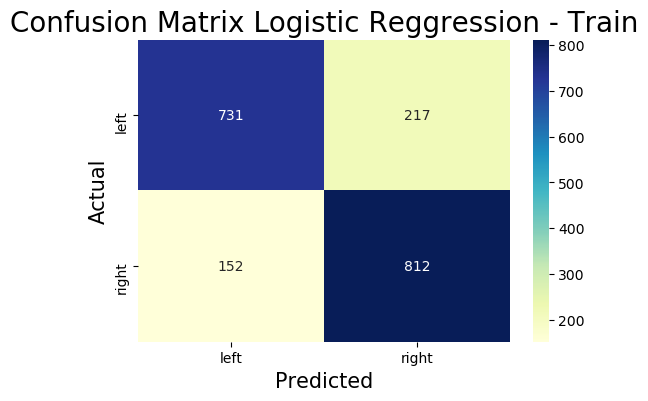

In [58]:
X_train,X_test,y_train,y_test=train_test_split(Xdf,left_right_res,test_size=0.25,random_state=0)
logreg = LogisticRegression(class_weight = 'balanced')
#X_train= np.array(X_train).reshape(-1, 1)
#X_test = np.array(X_test).reshape(-1, 1)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_train)
cnf_matrix = metrics.confusion_matrix(y_train,y_pred)
plt.figure(dpi=100)
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="YlGnBu",yticklabels=['left','right'],xticklabels=['left','right'])
cnf_matrix = metrics.confusion_matrix(y_train,y_pred)
total_accuracy = (cnf_matrix[0, 0] + cnf_matrix[1, 1]) / float(np.sum(cnf_matrix))
class1_accuracy = (cnf_matrix[0, 0] / float(np.sum(cnf_matrix[0, :])))
class2_accuracy = (cnf_matrix[1, 1] / float(np.sum(cnf_matrix[1, :])))
plt.title('Confusion Matrix Logistic Reggression - Train', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15)
print('Total accuracy: %.5f' % total_accuracy)
print('Class1 accuracy: %.5f' % class1_accuracy)
print('Class2 accuracy: %.5f' % class2_accuracy)
print('Geometric mean accuracy: %.5f' % math.sqrt((class1_accuracy * class2_accuracy)))
LogisticAcc =math.sqrt((class1_accuracy * class2_accuracy))
LogisticAcc =math.sqrt((class1_accuracy * class2_accuracy))

Logistic Reggression prediction

Total accuracy: 0.80251
Class1 accuracy: 0.75896
Class2 accuracy: 0.84290
Geometric mean accuracy: 0.79983


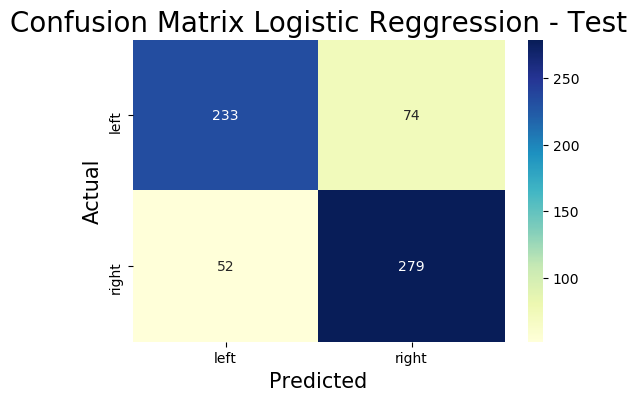

In [11]:
X_train,X_test,y_train,y_test=train_test_split(Xdf,left_right_res,test_size=0.25,random_state=0)
logreg = LogisticRegression(class_weight = 'balanced')
#X_train= np.array(X_train).reshape(-1, 1)
#X_test = np.array(X_test).reshape(-1, 1)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
plt.figure(dpi=100)
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="YlGnBu",yticklabels=['left','right'],xticklabels=['left','right'])
plt.title('Confusion Matrix Logistic Reggression - Test', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15)
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
total_accuracy = (cnf_matrix[0, 0] + cnf_matrix[1, 1]) / float(np.sum(cnf_matrix))
class1_accuracy = (cnf_matrix[0, 0] / float(np.sum(cnf_matrix[0, :])))
class2_accuracy = (cnf_matrix[1, 1] / float(np.sum(cnf_matrix[1, :])))
print('Total accuracy: %.5f' % total_accuracy)
print('Class1 accuracy: %.5f' % class1_accuracy)
print('Class2 accuracy: %.5f' % class2_accuracy)
print('Geometric mean accuracy: %.5f' % math.sqrt((class1_accuracy * class2_accuracy)))
LogisticAcc =math.sqrt((class1_accuracy * class2_accuracy))
LogisticAcc =math.sqrt((class1_accuracy * class2_accuracy))

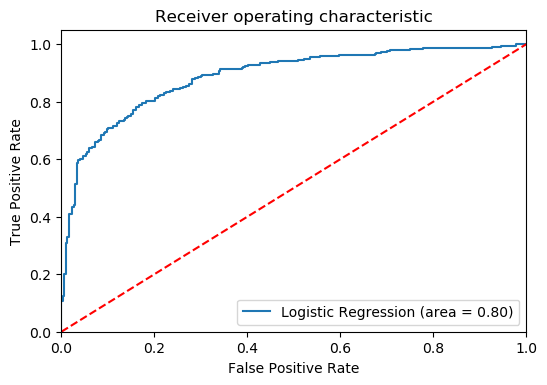

In [57]:
#roc curve Logistic Reggression 
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = metrics.roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(dpi=100)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [19]:
models = pd.DataFrame({
    'Model': [ 'Logistic Regression','Stochastic Gradient Decent', 'Random Forest',
           'Decision Tree','Perceptron', 'Support Vector Machines','Linear SVC'
             ],
    'Score': [LogisticAcc, SgdAcc, RandomForestAcc, 
              DecisionTreeAcc, PerceptronAcc, 
              SvcAcc, LinearSvcAcc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
5,Support Vector Machines,0.816095
1,Stochastic Gradient Decent,0.810735
4,Perceptron,0.810371
2,Random Forest,0.807707
0,Logistic Regression,0.799829
6,Linear SVC,0.790541
3,Decision Tree,0.747808


Interactive

In [24]:
app = Display(2,9)
app.container

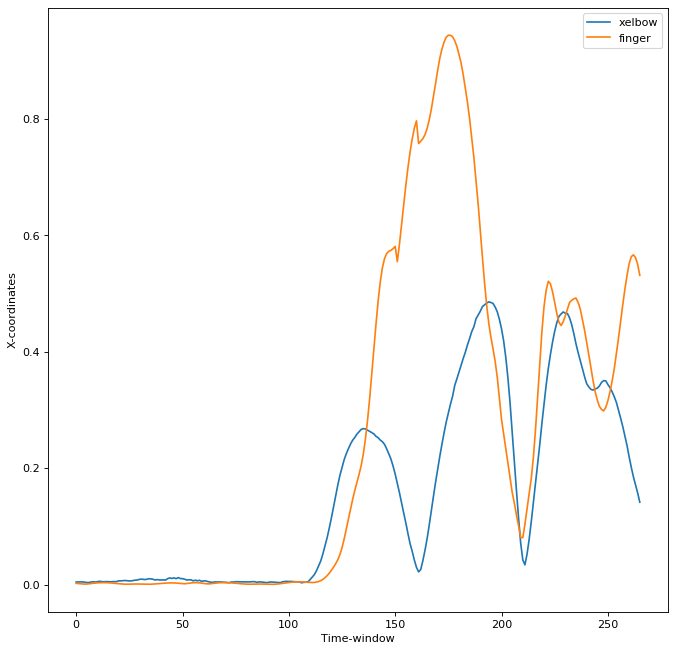

In [51]:
stdFingerHead(2,10)

(0, 300)

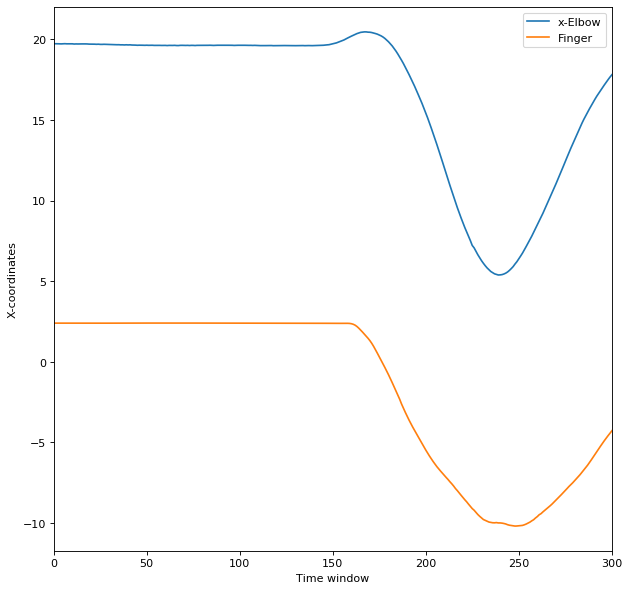

In [56]:
plt.figure(figsize=(9, 9), dpi=80)
plt.plot(df_trail[2][9][['xAs4']],label='x-Elbow')
plt.plot(df_trail[2][9][[' xA ']],label='Finger')
plt.legend()
plt.xlabel('Time window')
plt.ylabel('X-coordinates')
plt.xlim(xmin=0,xmax=300)